# Proximity Analysis: Classical vs Quantum Feature Mapping

This notebook demonstrates a proximity analysis use case: comparing classical nearest-neighbor (distance-based) methods against a quantum feature-map (kernel) approach. The example generates synthetic 2D clusters, computes classical distances and a quantum kernel (statevector fidelity) after encoding features into small quantum circuits, and compares neighborhood structure and k-NN classification performance.

In [1]:
# Requirements: imports and (optional) installs
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

# Qiskit imports (try to import; if missing, raise helpful message)
try:
    from qiskit import QuantumCircuit, transpile
    from qiskit_aer import AerSimulator
except Exception as e:
    raise ImportError("Qiskit and qiskit-aer are required to run the quantum parts. Install with: pip install qiskit qiskit-aer") from e

np.random.seed(42)

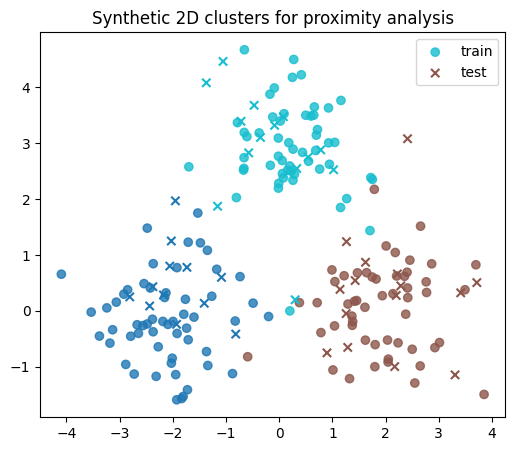

In [2]:
# Generate synthetic 2D data for proximity analysis
X, y = make_blobs(n_samples=200, centers=[[-2,0],[2,0],[0,3]], cluster_std=0.8, random_state=42)
# Introduce a few nearby outliers to show proximity differences
outliers = np.array([[0.2, 0.0],[0.3, 0.2],[-0.2,-0.1]])
outlier_labels = np.array([2,2,0])
X = np.vstack([X, outliers])
y = np.concatenate([y, outlier_labels])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Quick scatter plot of the dataset
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='tab10', alpha=0.8, label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', marker='x', label='test')
plt.title('Synthetic 2D clusters for proximity analysis')
plt.legend()
plt.show()

## Classical proximity: k-NN and distances

We compute Euclidean distances and run a classical k-NN (k=3) as a baseline for proximity-based classification and neighborhood analysis.

In [3]:
# Classical k-NN baseline
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
acc_classical = knn.score(X_test, y_test)
print(f'Classical k-NN (k={k}) accuracy: {acc_classical:.3f}')

# Function to compute euclidean nearest neighbors (indices) for visualization
def euclidean_neighbors(X_ref, X_query, k=3):
    d = np.linalg.norm(X_query[:,None,:] - X_ref[None,:,:], axis=2)
    return np.argsort(d, axis=1)[:,:k], d

nn_idx_euc, d_euc = euclidean_neighbors(X_train, X_test, k=k)
print('Example nearest neighbors (by index) for first 5 test points:', nn_idx_euc[:5])

Classical k-NN (k=3) accuracy: 0.927
Example nearest neighbors (by index) for first 5 test points: [[ 74 145 136]
 [138 148  30]
 [ 70  49 109]
 [107 129 127]
 [ 47 140  50]]


## Quantum feature map & kernel

We encode 2D features into a small quantum circuit using angle encoding (Ry rotations). For each data point we prepare the statevector and compute the fidelity (squared overlap) between pairs to obtain a similarity/kernel matrix S. We convert similarity to a distance measure using `d_q(x,y) = 1 - S(x,y)` and perform a simple k-NN using that distance.

In [5]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

sim = AerSimulator(method="statevector")

def feature_circuit(x):
    qc = QuantumCircuit(2)
    angles = np.clip(x, -5, 5)
    qc.ry(angles[0], 0)
    qc.ry(angles[1], 1)
    qc.save_statevector()   # <-- critical
    return qc

def statevector_for(x):
    qc = feature_circuit(x)
    tqc = transpile(qc, sim)
    result = sim.run(tqc).result()
    sv = result.get_statevector(tqc)  # now it exists
    return np.array(sv)

sv_train = [statevector_for(x) for x in X_train]
sv_test  = [statevector_for(x) for x in X_test]


In [6]:
# # Quantum encoding: 2 qubits, angle encoding of two features
# def feature_circuit(x):
#     # x: length-2 vector scaled to rotation angles
#     qc = QuantumCircuit(2)
#     # Normalize or scale features to [-pi, pi]
#     angles = np.clip(x, -5, 5)  # crude clipping to keep values reasonable
#     # scale to [-pi, pi]
#     angles = (angles - angles.min()) if False else angles  # no-op placeholder
#     qc.ry(angles[0], 0)
#     qc.ry(angles[1], 1)
#     return qc

# # Helper to get statevector for a circuit
# sim = AerSimulator(method='statevector')
# def statevector_for(x):
#     qc = feature_circuit(x)
#     tqc = transpile(qc, sim)
#     job = sim.run(tqc)
#     result = job.result()
#     sv = result.get_statevector(tqc)
#     return np.array(sv)

# # Build statevectors for training and test sets (small dataset is required)
# sv_train = [statevector_for(x) for x in X_train]
# sv_test = [statevector_for(x) for x in X_test]

# Compute fidelity-based similarity S_ij = |<psi_i|psi_j>|^2
def fidelity(sv1, sv2):
    ov = np.vdot(sv1, sv2)
    return np.abs(ov)**2

# Training-training kernel (useful for precomputed distance if needed)
S_train = np.zeros((len(sv_train), len(sv_train)))
for i in range(len(sv_train)):
    for j in range(len(sv_train)):
        S_train[i,j] = fidelity(sv_train[i], sv_train[j])

# Test-training similarity matrix
S_test_train = np.zeros((len(sv_test), len(sv_train)))
for i in range(len(sv_test)):
    for j in range(len(sv_train)):
        S_test_train[i,j] = fidelity(sv_test[i], sv_train[j])

# Convert similarity to distance: d = 1 - S
D_test_train = 1.0 - S_test_train

print('Computed quantum kernel (fidelity) distances for test vs train.')

Computed quantum kernel (fidelity) distances for test vs train.


In [7]:
# Simple k-NN prediction using precomputed distance matrix (test vs train)
def knn_predict_from_distance(D_test_train, y_train, k=3):
    preds = []
    for i in range(D_test_train.shape[0]):
        idx = np.argsort(D_test_train[i])[:k]
        lab = Counter(y_train[idx]).most_common(1)[0][0]
        preds.append(lab)
    return np.array(preds)

y_pred_q = knn_predict_from_distance(D_test_train, y_train, k=3)
acc_quantum = np.mean(y_pred_q == y_test)
print(f'Quantum-kernel k-NN accuracy: {acc_quantum:.3f}')

# Compare with classical distance-based predictions using our euclidean neighbor indices
# Build test-vs-train euclidean distances (for fair comparison)
d_test_train = np.linalg.norm(X_test[:,None,:] - X_train[None,:,:], axis=2)
y_pred_euc = knn_predict_from_distance(d_test_train, y_train, k=3)
acc_euclidean = np.mean(y_pred_euc == y_test)
print(f'Euclidean k-NN (manual) accuracy: {acc_euclidean:.3f}')

print('Summary: classical acc, quantum acc ->', acc_euclidean, acc_quantum)

Quantum-kernel k-NN accuracy: 0.805
Euclidean k-NN (manual) accuracy: 0.927
Summary: classical acc, quantum acc -> 0.926829268292683 0.8048780487804879


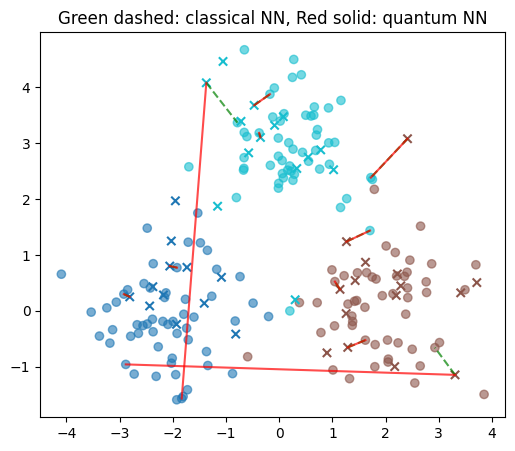

In [8]:
# Visualization: show first 10 test points and their classical vs quantum nearest neighbor in training set
def plot_neighbors(idx_list, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='tab10', alpha=0.6)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', marker='x')
    for i in idx_list:
        # classical NN
        nn_e = nn_idx_euc[i,0]
        plt.plot([X_test[i,0], X_train[nn_e,0]], [X_test[i,1], X_train[nn_e,1]], 'g--', alpha=0.7)
        # quantum NN (closest by fidelity distance)
        q_nn = np.argmin(D_test_train[i])
        plt.plot([X_test[i,0], X_train[q_nn,0]], [X_test[i,1], X_train[q_nn,1]], 'r-', alpha=0.7)
    plt.title(title)
    plt.show()

plot_neighbors(list(range(min(10, len(X_test)))), 'Green dashed: classical NN, Red solid: quantum NN')

## Notes and next steps
- The quantum kernel used here is the squared fidelity of small feature-encoding circuits. For larger/real datasets use more advanced feature maps or Qiskit Machine Learning's `QuantumKernel`.
- This demo intentionally uses a tiny circuit (2 qubits) and angle encoding to keep execution on a local simulator fast.
- Compare different encodings, kernel-to-distance transforms, and larger `k` values to explore proximity sensitivity.
- To run on hardware, convert the kernel estimation to an uncertainty-aware estimator (shots-based) and consider noise mitigation.